<a href="https://colab.research.google.com/github/SPS-L/pyeplan/blob/master/examples/Watoto_Village_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Designing a Sustainable Energy Solution for Watoto Suubi Village Using PyEPLAN

PyEPLAN was utilised to design a Microgrid on Watoto Village in Uganda. This village sits on a 194-acre site with four schools ranging from kindergarten to vocational, a clinic, church, playgrounds, and home clusters that house the orphan children. Each home cluster houses nine houses, with a total of 180 homes are available on site.

PyEPLAN was utilised to design a sustainable energy solution to meet the different electric power needs of the village.


## Preparing the platform to execute the PyEPLAN software

Importing data files:

In [ ]:
#@markdown The following commands import the folders containing the technical data specifications of the village.  

!rm -r sample_data
!rm -r pyeplan

In [ ]:
#@title 

!git clone https://github.com/SPS-L/pyeplan.git
!cd pyeplan/examples

Installing solver programs:

In [ ]:
#@markdown The optimisation solver programs are installed into the platform using these commands.

!apt-get install -y -qq glpk-utils                       &> /dev/null
!apt-get install -y -qq coinor-cbc                       &> /dev/null
!pip install gurobipy                                    &> /dev/null
!pip install -q pyomo &> /dev/null
!pyomo install-extras &> /dev/null

Installing PYEPLAN:

In [ ]:
#@markdown These next commands install PyEPLAN software and import all its modules into the Colab platfrom 

!pip install -q pyeplan==1.1.3                 &> /dev/null

In [1]:
#@title 

import pyeplan as pe

## Using the PyEPLAN Data Processing Module

#### The PyEPLAN Data Processing Module was used to obtain the PV generation profiles at the village location

The Data Processing Module can be used to obtain the photovoltaic (PV) system energy production i.e., PV generation profiles at any location. The user therefore needs to define the GPS coordinates of the location where they need to obtain PV profiles. The Data Processing Module is initialised with inputs including the following :
* lat: This input sets the latitude of the location where profiles are required.
* lon: This input sets the longtitude of the location where profiles are required.
* year: The year for which to obtain profiles is set using this input. 
* n_clust: This input is used to set the number of representative days i.e., operational scenarios, to be used during during system planning.

In [2]:
#@markdown The following command is used to set the input arguments.

datsys = pe.datsys('wat_inv', lat=0.251148605450955, lon=32.404833929733, year=2016, n_clust=2, pp=100)

Normalized column names: ['time', 'P', 'Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'Int']


In [3]:
#@markdown The following command extract the PV generation data.
 

datsys.data_extract()

Available columns in PVGIS 5.3 data: ['time', 'P', 'Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'Int', 'date', 'hour']


/home/apetros/OneDriveCUT/Code/PyEPlan/pyeplan/dataproc.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_local_time['G(i)'] = self.data_local_time['Gb(i)'] + self.data_local_time['Gd(i)'] + self.data_local_time['Gr(i)']


In [4]:
#@markdown The following command is used to obtain the operational scenarios required.


datsys.kmeans_clust()

✓ PVGIS 5.3 data processing completed successfully
✓ Generated 2 scenarios for optimization
✓ All required files created in wat_inv


In [5]:
#@title 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

df=pd.read_csv("wat_inv/psol_dist.csv")
fig = px.line(df, title='Representatative Daily Solar Power Generation for Different Scenarios', labels={
                     "value": "Power Generation (kW)",
                     "index": "Time of Day",
                     "variable": "Scenario"
                 },width=600, height=400,)

fig.update_layout(title_x=0.5, font=dict(
            size=12,
            color='#000000'
        ))
fig.show()


## Using the PyEPLAN Feeder Routing Module

#### This module was used in designing the distribution network layout for the village.

The module requires the files with technical specifications of the system to perform the feeder routing. It takes in files containing the geographical location of load points and characteristic of different cables to undertake this task. See details of input files [here](https://pyeplan.sps-lab.org/user_guide/input.html#csv-file-name-geol-dist-rarr-geographical-location-of-load-points-for-feeder-routing).

The input arguments for the module include:

* Name of folder with the csv files containing technical parameters.
* crs: Cross section of cables \[mm]
* typ: Type of cables

In [6]:
#@markdown The following commands set the input arguments and perform the feeder routing.
 
rousys = pe.rousys('wat_inv')

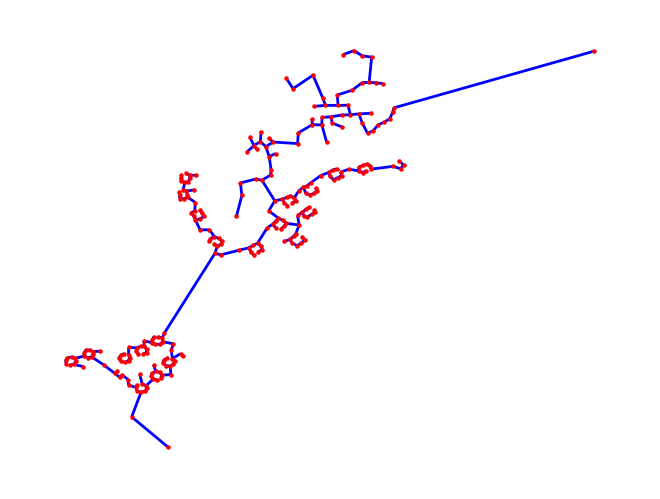

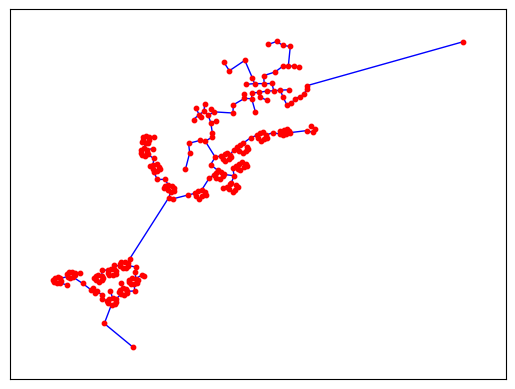

In [7]:
#@title 

rousys.min_spn_tre()

## Using the PyEPLAN Investment and Operational Planning Module

#### This module is used to determine the design an optimal energy generation solution for the village. 

PyEPLAN solves the investment and operation planning problems simultaneously. 

The planning problem will be solved based on the input arguments set by the user. Some of the planning options that need to be set by the user include the following:

* If the user has pre-defined sizes of the investment candidates the input '**invest = True**' i.e., unit capacity = maximum capacity. Otherwise, if the user has no knowledge of the size of the candidates, these can be optimally derived by the software by setting '**invest = False**' where the unit capacity <= maximum capacity.

* The user can set solver program by defining the input to the '**solver**'. Options include both open source solvers include glpk, cbc, and commercial solvers ipopt, gurobi given one has the required licences. 

* If the user desires only to solve an operation planning problem, this can be ensured by setting input 'onlyopr = True'.

In [8]:
#@markdown The commands below is set the input arguments to required by the module and solve the microgrid planning problem.

inosys = pe.inosys('wat_inv', ref_bus = 260)

In [9]:
#@title 

inosys.solve(solver = 'cbc', onlyopr = False, invest = True)

### Watoto Village Optimal Design Solution

#### Total Investment and Operational Costs

In [10]:
#@title 

inosys.resCost()

,total costs,86983.442
0,total investment costs,57076.685
1,total operation costs,29906.757


#### Number and capacity of battery units installed

In [11]:
#@title 
inosys.resBat()

,Installed Capacity (kW),Bus
Unit,,
1,50.0,260
2,50.0,260
3,0.0,260
4,0.0,260
5,0.0,260


#### Number and capacity of solar units installed

In [12]:
#@title 

inosys.resSolar()

,Installed Capacity (kW),Bus
Unit,,
1,100.0,260
2,0.0,260
3,100.0,260
4,0.0,260
5,0.0,260


#### Number and capacity of diesel units installed

In [13]:
#@title 

inosys.resConv()

,Installed Capacity (kW),Bus
Unit,,
1,50.0,260
2,0.0,260
